In [125]:
import re
import numpy as np
import pandas as pd
import nltk
import unicodedata
import csv
import itertools
from tqdm.notebook import trange, tqdm
from nltk import word_tokenize, pos_tag, corpus
from nltk.stem import WordNetLemmatizer
from collections import defaultdict, Counter

In [7]:
# Read in the datasets
df_directions = pd.read_excel('/Users/nessyliu/Desktop/RA/AllRecipes_Directions_2019-11-26.xlsx')
df = pd.read_csv('/Users/nessyliu/Desktop/RA/AllReviews_26thNov2019.csv')
df_ingredients_raw = pd.read_csv('/Users/nessyliu/Desktop/RA/part_2/Ingredients.csv')
df_cluster = pd.read_excel('/Users/nessyliu/Desktop/RA/part_2/Cluster_names.xlsx')

df_ingre_clean = pd.read_csv('/Users/nessyliu/Desktop/RA/part_2/ingredients_after_text_cleaning.csv')
df_mod = pd.read_excel('/Users/nessyliu/Desktop/RA/part_2/Final_clusters_mod.xlsx')

In [179]:
df_ingre_clean.loc[df_ingre_clean['raw_id'] == 16386,:].head()

,recipe_id,recipe_url,raw_id,ingredient_text,ingredient_clean_text
464241,17652,https://www.allrecipes.com/recipe/17652/banana...,16386,1/8 teaspoon ground cinnamon,ground cinnamon
464242,6865,https://www.allrecipes.com/recipe/6865/to-die-...,16386,1 1/2 teaspoons ground cinnamon,ground cinnamon
464243,6698,https://www.allrecipes.com/recipe/6698/moms-zu...,16386,1 tablespoon ground cinnamon,ground cinnamon
464244,6820,https://www.allrecipes.com/recipe/6820/downeas...,16386,1 teaspoon ground cinnamon,ground cinnamon
464245,20156,https://www.allrecipes.com/recipe/20156/clone-...,16386,2 1/2 tablespoons ground cinnamon,ground cinnamon


In [40]:
df_mod.loc[df_mod['cluster_name'] == 'ground cinnamon',:]
# df_mod.loc[df_mod['label2'] == 'beef sirloin',:]

,raw_id,cluster_name,totalcount,label2
33,16386,ground cinnamon,5862,ground cinnamon
34,21236,ground cinnamon,1,mccormick ground cinnamon
35,32183,ground cinnamon,1,ground ceylon cinnamon


In [15]:
full_directions_list = []
recipe_id_list = list(set(df_directions.recipe_id.tolist()))
for recipe_id in recipe_id_list:
    full_dir_this_recipe = ' '.join(df_directions.loc[df_directions['recipe_id']==recipe_id, 'directions_step_text'])
    full_directions_list.append(full_dir_this_recipe)
dict_recipe_direction = dict(zip(recipe_id_list, full_directions_list))

In [16]:
# list of cluster names with spaces (e.g. apple juice) sorted by number of words in each name, 
# e.g. "apple juice" should appear before "juice"
cluster_name_orig_list = df_cluster.cluster_name.tolist()
cluster_name_orig_list.sort(key=lambda x: len(x.split()), reverse=True)

# create dict to map recipe_id to ingredient_ids
df_ingredients = df_ingredients_raw.groupby('recipe_id')['ingredient_id'].apply(list).reset_index(name ='ingredients')
dict_recipe_ingredients = dict(zip(df_ingredients.recipe_id, df_ingredients.ingredients))

# create dict to map ingredient_id to cluster_name
df_cluster = df_cluster.replace(' ', '_', regex=True)
dict_ingredient_clustername = dict(zip(df_cluster.ingredient_id, df_cluster.cluster_name))

In [319]:
# lemmatization dict
lemma_list = pd.read_csv('/Users/nessyliu/Desktop/RA/lemma_list.csv')
lemma_dict = lemma_list.set_index('word_list').to_dict()['lemma_list']

def lemmatization(text):
    
    text = text.lower()
    
    text = text.replace('lowfat','low fat').replace('nonfat','non fat').replace('glutenfree','gluten free').replace('corn flakes','cornflakes')
    
    text = text.replace('coconutmilk','coconut milk').replace('almondmilk','almond milk').replace('crab meat','crabmeat').replace('starfruit', 'star fruit')
    
    # use the custom lemma dict first
    text = " ".join(str(lemma_dict.get(word, word)) for word in text.split())
    
    # then use the WordNetLemmatizer from nltk
    wnl = WordNetLemmatizer()
    # lemmatize each word based on its pos tagging
    text_after = " ".join([wnl.lemmatize(i,j[0]) if j[0] in ['a','n','v'] else wnl.lemmatize(i) for i,j in pos_tag(word_tokenize(text))])    
    return text_after

In [320]:
unigram_exclude_list = ['purpose','extra', 'whole', 'frying', 'cut',
                        'sun', 'baby', 'five', 'star',
                        'white', 'green', 'black', 'red', 'pink', 'yellow', 'brown', 'golden', 'blue', 
                        'color', 'colored',
                        'ground', 'sea', 'part', 'baked', 'raw', 'new', 'active',
                        'italian', 'dark', 'light', 'fresh', 'sweet', 'candied',
                        'dried', 'dry', 'heavy', 'condensed', 'firm', 'free', 'mixed', 'flavored', 'evaporated',
                        'hot', 'self', 'rising', 'split', 'cooking', 'stewed',
                        'de', 'dr']
unigram_exclude_list += corpus.stopwords.words('english')

ngram_exclude_list = ['all_purpose', 'purpose_flour', 'free_all']

ngram_not_start_end = ['for', 'of', 'and', 'with', 'in']

In [321]:
valid_recipe_id_list = []
perfect_match_list = []
partial_match_list = []
no_match_list = []
recipe_list = []
direction_list = []
lemmatized_direction_list = []

num_ingredient_list = []
num_perfect_match_list = []
num_partial_match_list = []
num_no_match_list = []

count_invalid = 0
for recipe_id in tqdm(recipe_id_list):
    
    # list of ingre that appeared exactly the same in the direction
    perfect_match_this_recipe = []
    # list of ingre that matched shorter form in the direction
    partial_match_this_recipe = []
    # list fo ingre that are not matched
    no_match_this_recipe = []
    
    # count number of ingredients
    num_perfect_match_this_recipe = 0
    num_partial_match_this_recipe = 0
    num_no_match_this_recipe = 0

    # get the ingredients of this recipe id
    try:
        recipe = [dict_ingredient_clustername[ingre_id] for ingre_id in dict_recipe_ingredients[recipe_id]]
        valid_recipe_id_list.append(recipe_id)
        recipe.sort(key=lambda x: len(x.split('_')), reverse=True)
        
        recipe.sort(key=lambda x: len(x.split('_')), reverse=True)
        
        # get the direction of this recipe id
        direction = dict_recipe_direction[recipe_id]
        lemmatized_direction = lemmatization(dict_recipe_direction[recipe_id])
        # map each ingredient to the words in the direction
        for ingre in recipe:
            ingre_tokens = ingre.split('_')
            ingre_original = ' '.join(ingre_tokens)
            if ingre_original in direction or ingre_original in lemmatized_direction:
                perfect_match_this_recipe.append(ingre)
                num_perfect_match_this_recipe += 1
            else:
                partial_match_this_ingre = []
                if len(ingre_tokens) > 1:
                    n = len(ingre_tokens)-1
                    while n > 0: # length of the short form
                        for i in range(0,len(ingre_tokens)-n+1): # start index in the full cluster name
                            short_form = ' '.join(ingre_tokens[i:i+n])
                            if short_form in direction or short_form in lemmatized_direction:
                                # the short form is a map to the ingre
                                # don't break the loop if matched, cuz 'oil for frying' may end up matched 'for frying' and break
                                # but ignore subsequence part, e.g. if 'firm tofu' is matched, ignore 'firm' & 'tofu'
                                if not any(short_form in existing_short_form for existing_short_form in partial_match_this_ingre):
                                    if n > 1: # if the short form >=2 words
                                        if short_form.replace(' ','_') not in ngram_exclude_list\
                                            and ingre_tokens[i] not in ngram_not_start_end \
                                            and ingre_tokens[i+n-1] not in ngram_not_start_end:
                                                # if the short form not in ngram_exclude_list
                                                # and the short form does not start or end with words in ngram_not_start_end list
                                                partial_match_this_ingre.append(short_form.replace(' ','_'))
                                    else: # if the short form is unigram
                                        if short_form not in unigram_exclude_list:
                                            partial_match_this_ingre.append(short_form)

                        n -= 1
                if len(partial_match_this_ingre) == 0:
                    no_match_this_recipe.append(ingre)
                    num_no_match_this_recipe += 1
                else:
                    partial_match_this_recipe.append([ingre, partial_match_this_ingre])
                    num_partial_match_this_recipe += 1

        recipe_list.append(recipe)
        direction_list.append(direction)
        lemmatized_direction_list.append(lemmatized_direction)
        perfect_match_list.append(perfect_match_this_recipe)
        partial_match_list.append(partial_match_this_recipe)
        no_match_list.append(no_match_this_recipe)
        num_perfect_match_list.append(num_perfect_match_this_recipe)
        num_partial_match_list.append(num_partial_match_this_recipe)
        num_no_match_list.append(num_no_match_this_recipe)
        num_ingredient_list.append(len(recipe))
    
    
    except:
        count_invalid += 1
        continue

matched_df = pd.DataFrame({
    'recipe_id': valid_recipe_id_list, 
    'recipe': recipe_list,
    'direction': direction_list,
    'lemma_direction': lemmatized_direction_list,
    'perfect_match': perfect_match_list,
    'partial_match': partial_match_list,
    'no_match': no_match_list,
    'num_ingredient': num_ingredient_list,
    'num_perfect_match': num_perfect_match_list,
    'num_partial_match': num_partial_match_list,
    'num_no_match': num_no_match_list
})

In [322]:
print(matched_df.shape)
matched_df.to_csv('/Users/nessyliu/Desktop/RA/part_2/result/matched_directions__w4.csv')

(57709, 11)


In [215]:
# # test the 1-gram to (n-1)-gram shorter forms
# ingre_tokens = ['fresh','white','chocolate','chips']

# n = len(ingre_tokens)-1
# while n > 0:
#     for i in range(0,len(ingre_tokens)-n+1):
#         short_form = ' '.join(ingre_tokens[i:i+n])
#         print(short_form)
#     n = n-1

## Count of ingredients not matched in all recipe directions

In [323]:
no_match_list_flat = list(itertools.chain.from_iterable(no_match_list))
count_no_match = Counter(no_match_list_flat)
count_no_match.most_common()

[('walnut', 767),
 ('salt', 662),
 ('garbanzo_bean', 223),
 ('white_sugar', 203),
 ('green_onion', 202),
 ('ground_cinnamon', 195),
 ('margarine', 187),
 ('water', 186),
 ('dry_active_yeast', 185),
 ('butter', 182),
 ('pecan', 181),
 ('graham_cracker', 160),
 ('all_purpose_flour', 152),
 ('pie_crust', 143),
 ('ground_nutmeg', 124),
 ('egg', 123),
 ('vanilla_extract', 120),
 ('crabmeat', 109),
 ('baking_soda', 104),
 ('ground_beef', 93),
 ('ground_black_pepper', 87),
 ('vegetable_oil', 82),
 ('ground_clove', 81),
 ('brown_sugar', 81),
 ('green_chile_pepper', 78),
 ('baking_powder', 73),
 ('honey', 72),
 ('spaghetti', 69),
 ('macaroni', 69),
 ('luncheon_meat', 64),
 ('milk', 64),
 ('onion', 63),
 ('bread_crumb', 62),
 ('raisin', 60),
 ('adobo_sauce', 59),
 ('garlic', 59),
 ('sirloin', 59),
 ('milk_powder', 57),
 ('club_soda', 55),
 ('ground_allspice', 55),
 ('ground_ginger', 55),
 ('jam', 54),
 ('sweetener', 53),
 ('carrot', 53),
 ('half_and_half', 53),
 ('italian_seasoning', 51),
 ('pot

### Findings from looking into the above missing ingredients:

Different Types of missing:
- Synonyms: such as green onion (in recipe) with scallion (in direction)
- Short form within word: such as "crab" (in direction) for "crabmeat" (in recipe)
- **Parent name**: such as "nut" (in direction) for "walnut" (in recipe). Details below:

For the recipes that have only 1 missing ingredient, we can check what happened one by one based on missing count.

For the recipes with more than one missing ingredients:

There are similar ingredients that are missing in recipe directions together.  

For example, for "walnut" (the most common missing ingredient), is always refered to as "nut" in the directions. Same for "pecan". In many recipes, they are both refered to as "nut" together (e.g. recipe id 7756 & 9490).

In some other cases, those ingredients (such as walnut) are all refered to as "dry ingredients" together (e.g. recipe id 6795). Perhaps to identify "dry ingredient" as a parent name for such clusters of ingredients. (e.g. When look at reviews, we can identify "I removed dry ingredient" as a deletion of the recipe ingredient "walnut".)

Also, "ground nutmeg" and "ground cinnamon" are refered to as "spices." (recipe id 6697)

Another example is meat. For example, "ground beef" and "pork sausage" are both missing in some directions, cuz are refered to as "meat" together (e.g. recipe id 140907), and also for "beef tenderloin", "beef part" (e.g. recipe id 12414). We can identify "meat" as a parent name of such cluster of ingredients. (e.g. When look at reviews, we can identify "I didn't use meat" as a deletion of the recipe ingredient "ground beef".)

Another example is "baking soda" and "all purpose flour" and "egg", they are all ingredients for baking so in many directions they are refered to as just "ingredients" (e.g. recipe id 7116). Perhaps this is one way to identify clusters of ingredients to ignore when doing the matching.

Thus, maybe a missing pattern analysis (below) can help to recognize such clusters.

## Ingredients missing pattern

In [324]:
# missing (no match) pattern
all_no_match_unique = set(no_match_list_flat)

In [325]:
matched_df_missing = matched_df.loc[:,['recipe_id', 'no_match']]

no_match_span_df = pd.concat([pd.Series(row['recipe_id'], row['no_match']) for _, row in tqdm(matched_df_missing.iterrows())]).reset_index()

In [326]:
no_match_span_df.columns = ['missing_ingredient', 'recipe_id']
missing_matrix = pd.pivot_table(no_match_span_df, values='missing_ingredient', index=['recipe_id'], columns=['missing_ingredient'], aggfunc=lambda x: len(x))

missing_matrix = missing_matrix.fillna(0)

missing_matrix.shape # row is each recipe, col is each (missing) ingre

# missing_matrix.insert(loc=0, column='recipe_id', value=missing_matrix.index)

(7285, 763)

There are 57709 recipes in total.
There are 7285 recipes with ingredients not matched.
There are 763 unique ingredients not matched in all 57709 recipes.
There are 744 unique ingredients not matched only in <= 100 recipes.
There are 19 unique ingredients not matched in > 100 recipes.


Text(0.5, 0, 'Not matched in # of recipes')

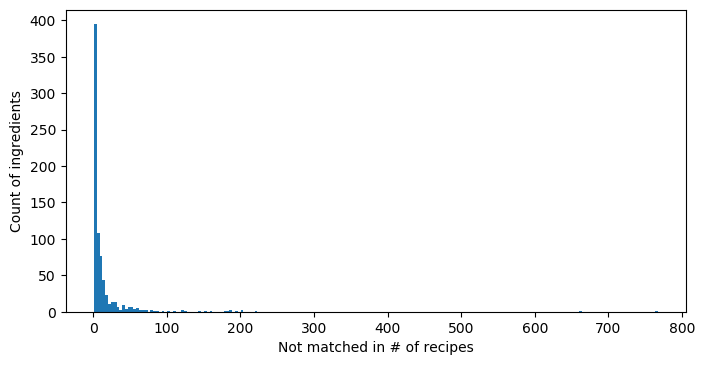

In [327]:
missing_in_num_recipes = [col_sum for col, col_sum in missing_matrix.sum().iteritems()]

thres = 100
print('There are', len(no_match_list), 'recipes in total.')
print('There are', len(missing_matrix), 'recipes with ingredients not matched.')
print('There are', len(all_no_match_unique), 'unique ingredients not matched in all',len(no_match_list),'recipes.')
print('There are', len([col_sum for col, col_sum in missing_matrix.sum().iteritems() if col_sum <= thres]), 'unique ingredients not matched only in <=', thres,'recipes.')
print('There are', len(all_no_match_unique) - len([col_sum for col, col_sum in missing_matrix.sum().iteritems() if col_sum <= thres]), 'unique ingredients not matched in >', thres,'recipes.')
plt.rcParams['figure.figsize'] = [8, 4]

np.random.seed(42)
plt.hist(missing_in_num_recipes, density=False, bins=200)
plt.ylabel('Count of ingredients')
plt.xlabel('Not matched in # of recipes')

In [328]:
# drop the ingredients that only not matched in <= thres recipes
# drop the recipes that contain more than 1 missing ingredient now

missing_matrix_drop = missing_matrix.copy()

missing_matrix_drop.drop([col for col, col_sum in tqdm(missing_matrix.sum().iteritems()) if col_sum <= thres], axis=1, inplace=True)
missing_matrix_drop = missing_matrix_drop.loc[(missing_matrix_drop.sum(axis=1) > 1),:]
missing_matrix_drop.shape

(593, 19)

In [329]:
corr_matrix = missing_matrix_drop.corr()

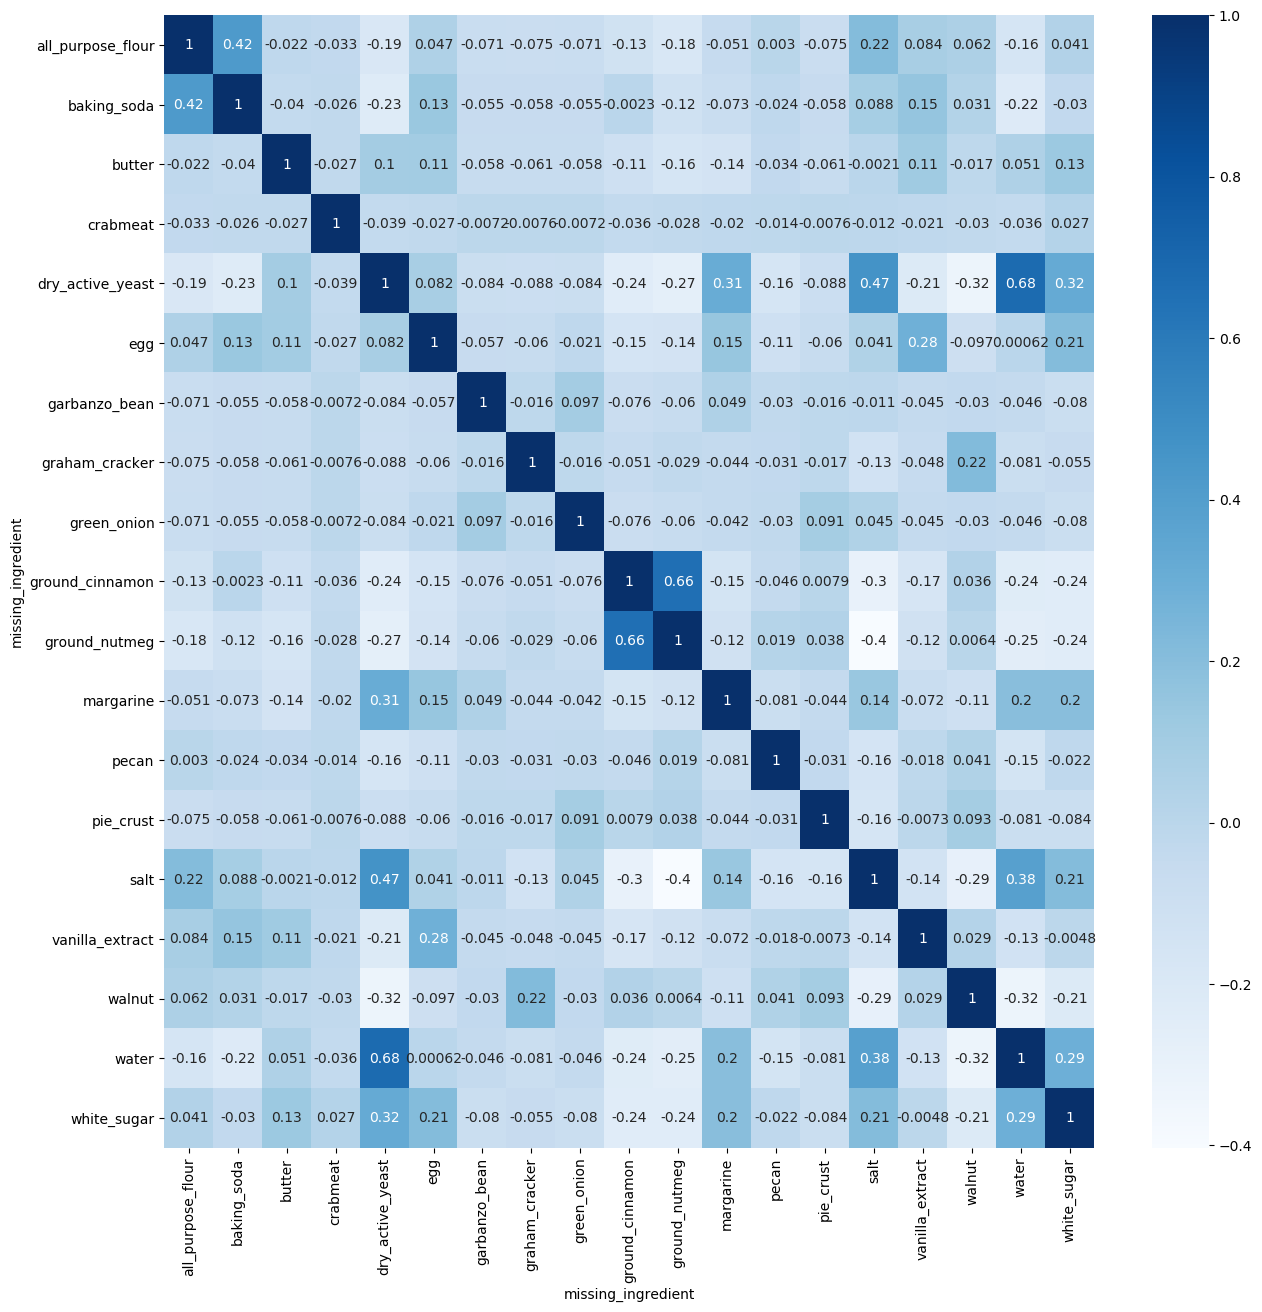

In [330]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 15]
sn.heatmap(corr_matrix, annot=True, cmap="Blues")
plt.show()

In [331]:
corr_matrix_lower = corr_matrix.copy()

corr_matrix_lower.loc[:,:] =  np.tril(corr_matrix_lower, k=-1) # borrowed from Karl D's answer

already_in = set()
missing_ingredients_clusters = []
for col in corr_matrix_lower:
    high_corr = corr_matrix_lower[col][corr_matrix_lower[col] > 0.02].index.tolist()
    if high_corr and col not in already_in:
        already_in.update(set(high_corr))
        high_corr.append(col)
        missing_ingredients_clusters.append(high_corr)


missing_ingredients_clusters


[['baking_soda',
  'egg',
  'salt',
  'vanilla_extract',
  'walnut',
  'white_sugar',
  'all_purpose_flour'],
 ['dry_active_yeast',
  'egg',
  'vanilla_extract',
  'water',
  'white_sugar',
  'butter'],
 ['white_sugar', 'crabmeat'],
 ['green_onion', 'margarine', 'garbanzo_bean'],
 ['walnut', 'graham_cracker'],
 ['ground_nutmeg', 'walnut', 'ground_cinnamon'],
 ['walnut', 'pecan'],
 ['walnut', 'pie_crust']]

In [332]:
# Create a dict using ingredient (cluster name) as key, 
# all appeared short forms (across all directions) as values, excluding meaningless terms (e.g. 'all','purpose','for')
all_short_forms = []
dict_ingre_shortforms = defaultdict(list)
for partial_match_this_recipe in partial_match_list:
    for partial_match_this_ingre in partial_match_this_recipe:
        ingre = partial_match_this_ingre[0]
        short_forms = partial_match_this_ingre[1]
        for short_form in short_forms:
            if short_form not in dict_ingre_shortforms[ingre]:
                all_short_forms.append(short_form)
                dict_ingre_shortforms[ingre].append(short_form)

In [333]:
count_short_forms = Counter(all_short_forms)
# count_short_forms.most_common()

## Manually add those mappings from above findings

In [334]:
### manually add some more mappings

# short form
dict_ingre_shortforms['crabmeat'].append('crab')

# Synonyms
dict_ingre_shortforms['garbanzo_bean'].append('chickpea')
dict_ingre_shortforms['green_onion'].append('scallion')
dict_ingre_shortforms['beef_sirloin'].append('steak')
dict_ingre_shortforms['espresso'].append('coffee_bean')
dict_ingre_shortforms['margarine'].append('butter')

# Parent
dict_ingre_shortforms['ground_cinnamon'].append('spice')
dict_ingre_shortforms['walnut'].append('nut')
dict_ingre_shortforms['ground_nutmeg'].append('nut')
dict_ingre_shortforms['pecan'].append('nut')

In [335]:
for key in dict_ingre_shortforms:
    print('\n',key)
    print(dict_ingre_shortforms[key])


 all_purpose_flour
['flour']

 other_milk
['milk']

 olive_oil
['oil', 'olive']

 ground_coriander
['coriander']

 ground_turmeric
['turmeric']

 cumin_seed
['cumin', 'seed']

 extra_virgin_olive_oil
['olive_oil', 'oil', 'virgin_olive_oil', 'virgin_olive', 'olive']

 ground_black_pepper
['pepper', 'black_pepper']

 split_pea
['pea']

 whole_milk
['milk']

 parmesan_cheese
['cheese', 'parmesan']

 red_bell_pepper
['bell_pepper', 'pepper', 'bell', 'red_bell']

 ground_cumin
['cumin']

 flavored_gelatin
['gelatin']

 granny_smith_apple
['apple', 'granny_smith']

 beef_stew_meat
['beef', 'meat', 'stew', 'stew_meat', 'beef_stew']

 vegetable_oil
['oil', 'vegetable']

 white_sugar
['sugar']

 whole_clove
['clove']

 oil_for_frying
['oil']

 ricotta_cheese
['cheese', 'ricotta']

 whole_kernel_corn
['corn', 'kernel', 'kernel_corn']

 white_rice
['rice']

 ground_nutmeg
['nutmeg', 'nut']

 white_vinegar
['vinegar']

 red_onion
['onion']

 green_chile_pepper
['chile', 'green_chile', 'pepper', '


 cassava_flour
['flour']

 parchment_paper
['paper', 'parchment']

 mustard_green
['mustard']

 jerk_seasoning
['seasoning']

 cinnamon_roll
['roll', 'cinnamon']

 garlic_paste
['garlic', 'paste']

 jelly_bean
['jelly', 'bean']

 sea_bass
['bass']

 peppermint_oil
['oil']

 tangerine_juice
['juice', 'tangerine']

 ham_bone
['bone']

 mozzarella_ball
['mozzarella', 'ball']

 cedar_plank
['plank']

 fish_sauce
['sauce']

 cheese_curd
['cheese']

 turkey_broth
['turkey', 'broth']

 melon_liqueur
['melon', 'liqueur']

 celery_root
['celery', 'root']

 burrata_cheese
['burrata', 'cheese']

 oyster_sauce
['sauce']

 garlic_scape
['scape', 'garlic']

 seasoned_pepper
['seasoned', 'pepper']

 coconut_flour
['coconut', 'flour']

 strawberry_extract
['extract']

 wheat_germ
['wheat']

 herbes_de_provence
['de_provence']

 duck_fat
['duck', 'fat']

 kitchen_twine
['twine']

 celery_salt
['celery', 'salt']

 cinnamon_chip
['cinnamon', 'chip']

 sour_cream
['cream']

 sparkling_wine
['wine']

 man

In [336]:
import csv

with open('/Users/nessyliu/Desktop/RA/part_2/result/dict_ingre_shortforms_w4.csv', 'w') as f:
    for key in dict_ingre_shortforms.keys():
        f.write("%s,%s\n"%(key,dict_ingre_shortforms[key]))